In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from src.pipeline import VietnameseNLPPipeline
from src.data_loader import VietnameseDatasetLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize pipeline
pipeline = VietnameseNLPPipeline('../configs/config.yaml')
data_loader = VietnameseDatasetLoader('../data')

print("Pipeline initialized successfully!")

INFO:src.tokenizer:Initialized Underthesea tokenizer
INFO:src.tokenizer:Initialized PyVi tokenizer
INFO:src.pos_tagger:Initialized Underthesea POS tagger
INFO:src.pos_tagger:Initialized PyVi POS tagger


Pipeline initialized successfully!


In [2]:
# Test simple sentences
test_sentences = [
    "Xin chào Việt Nam",
    "Tôi đang học xử lý ngôn ngữ tự nhiên",
    "Trường Đại học Bách khoa Hà Nội"
]

for sentence in test_sentences:
    print(f"\nInput: {sentence}")
    result = pipeline.process(sentence, verbose=True)
    print("-" * 50)

INFO:src.pipeline:Normalized: Xin chào Việt Nam



Input: Xin chào Việt Nam


INFO:src.pipeline:Tokens: ['Xin', 'chào', 'Việt Nam']
INFO:src.pipeline:POS tags: [('Xin', 'V'), ('chào', 'V'), ('Việt Nam', 'Np')]
INFO:src.pipeline:Normalized: Tôi đang học xử lý ngôn ngữ tự nhiên
INFO:src.pipeline:Tokens: ['Tôi', 'đang', 'học', 'xử lý', 'ngôn ngữ', 'tự nhiên']
INFO:src.pipeline:POS tags: [('Tôi', 'P'), ('đang', 'R'), ('học', 'V'), ('xử lý', 'V'), ('ngôn ngữ', 'N'), ('tự nhiên', 'A')]
INFO:src.pipeline:Normalized: Trường Đại học Bách khoa Hà Nội
INFO:src.pipeline:Tokens: ['Trường', 'Đại học', 'Bách khoa', 'Hà Nội']
INFO:src.pipeline:POS tags: [('Trường', 'N'), ('Đại học', 'N'), ('Bách khoa', 'N'), ('Hà Nội', 'Np')]


--------------------------------------------------

Input: Tôi đang học xử lý ngôn ngữ tự nhiên
--------------------------------------------------

Input: Trường Đại học Bách khoa Hà Nội
--------------------------------------------------


In [3]:
from src.tokenizer import VietnameseTokenizer

text = "Chàng trai 9X Quảng Trị khởi nghiệp từ nấm sò"

# Compare different tokenizers
tokenizers = {
    'underthesea': VietnameseTokenizer('underthesea'),
    'pyvi': VietnameseTokenizer('pyvi'),
    'hybrid': VietnameseTokenizer('hybrid')
}

print(f"Original text: {text}\n")
for name, tokenizer in tokenizers.items():
    tokens = tokenizer.tokenize(text)
    print(f"{name:12}: {' | '.join(tokens)}")

INFO:src.tokenizer:Initialized Underthesea tokenizer
INFO:src.tokenizer:Initialized PyVi tokenizer
INFO:src.tokenizer:Initialized Underthesea tokenizer
INFO:src.tokenizer:Initialized PyVi tokenizer
INFO:src.tokenizer:Initialized Underthesea tokenizer
INFO:src.tokenizer:Initialized PyVi tokenizer


Original text: Chàng trai 9X Quảng Trị khởi nghiệp từ nấm sò

underthesea : Chàng | trai | 9X | Quảng Trị | khởi nghiệp | từ | nấm | sò
pyvi        : Chàng | trai | 9X | Quảng_Trị | khởi_nghiệp | từ | nấm_sò
hybrid      : Chàng | trai | 9X | Quảng Trị | khởi nghiệp | từ | nấm | sò


INFO:src.data_loader:Loading Vietnamese Students' Feedback dataset...
INFO:src.data_loader:train: 1 samples
INFO:src.data_loader:validation: 1583 samples
INFO:src.data_loader:test: 3166 samples


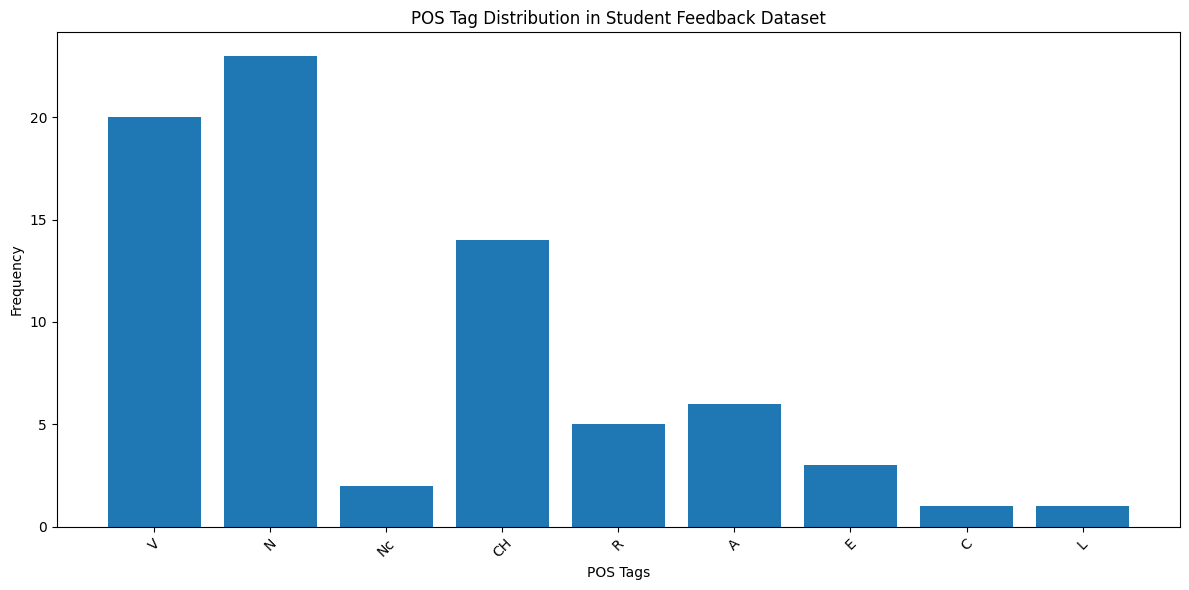

In [4]:
# Load student feedback dataset
student_feedback = data_loader.load_student_feedback()
test_df = student_feedback['test'].head(10)

# Process and analyze POS tags
pos_distribution = {}

for idx, row in test_df.iterrows():
    result = pipeline.process(row['sentence'])
    for token, tag in result.pos_tags:
        if tag not in pos_distribution:
            pos_distribution[tag] = 0
        pos_distribution[tag] += 1

# Visualize POS distribution
plt.figure(figsize=(12, 6))
tags = list(pos_distribution.keys())
counts = list(pos_distribution.values())

plt.bar(tags, counts)
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.title('POS Tag Distribution in Student Feedback Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
from src.tone_processor import ToneProcessor

tone_processor = ToneProcessor()

# Test tone removal and addition
test_cases = [
    "Việt Nam tươi đẹp",
    "Hôm nay trời mưa rất to",
    "Cảm ơn bạn đã giúp đỡ"
]

for text in test_cases:
    print(f"\nOriginal: {text}")
    
    # Remove tones
    no_tones = tone_processor.remove_tones(text)
    print(f"No tones: {no_tones}")
    
    # Add tones back
    restored = tone_processor.add_tones(no_tones)
    print(f"Restored: {restored}")
    
    # Analyze tones
    analysis = tone_processor.analyze_text(text)
    print(f"Tone distribution: {analysis['tone_distribution']}")


Original: Việt Nam tươi đẹp
No tones: Viet Nam tuoi dep
Restored: Việt nam tuổi dếp
Tone distribution: {'nặng': 2}

Original: Hôm nay trời mưa rất to
No tones: Hom nay troi mua rat to
Restored: Hôm nay trời mua rất tô
Tone distribution: {'huyền': 1, 'sắc': 1}

Original: Cảm ơn bạn đã giúp đỡ
No tones: Cam on ban da giup do
Restored: Cám ổn bạn đã giúp dô
Tone distribution: {'hỏi': 1, 'nặng': 1, 'ngã': 2, 'sắc': 1}


In [6]:
# Common errors in tokenization
error_examples = [
    ("Ông Nguyễn Văn A", ["Ông", "Nguyễn_Văn_A"]),  # Name handling
    ("21/12/2024", ["21/12/2024"]),  # Date handling
    ("email@example.com", ["email@example.com"]),  # Email handling
    ("Tp.HCM", ["Tp.", "HCM"]),  # Abbreviation
]

print("Common Tokenization Challenges:\n")
for text, expected in error_examples:
    result = pipeline.process(text)
    print(f"Input: {text}")
    print(f"Expected: {expected}")
    print(f"Got: {result.tokens}")
    print(f"Match: {result.tokens == expected}")
    print("-" * 40)

Common Tokenization Challenges:

Input: Ông Nguyễn Văn A
Expected: ['Ông', 'Nguyễn_Văn_A']
Got: ['Ông', 'Nguyễn Văn A']
Match: False
----------------------------------------
Input: 21/12/2024
Expected: ['21/12/2024']
Got: ['21/12/2024']
Match: True
----------------------------------------
Input: email@example.com
Expected: ['email@example.com']
Got: ['email@example.com']
Match: True
----------------------------------------
Input: Tp.HCM
Expected: ['Tp.', 'HCM']
Got: ['Tp.', 'HCM']
Match: True
----------------------------------------


Processed 10 sentences
Total time: 0.06 seconds
Average time per sentence: 5.74 ms
Sentences per second: 174.24


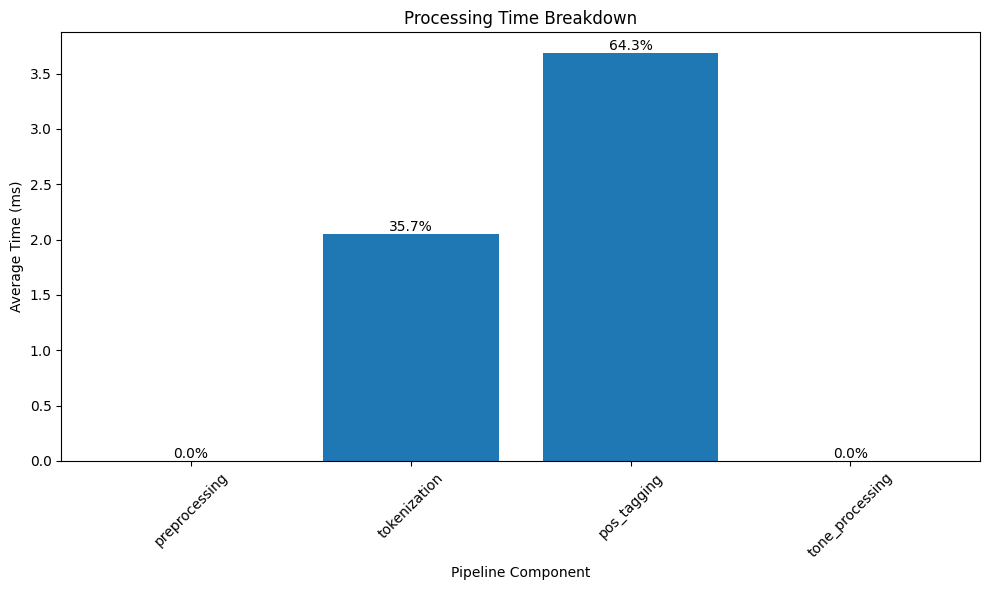

In [7]:
import time

# Measure processing speed
texts = test_df['sentence'].tolist()[:100]

start_time = time.time()
results = pipeline.process_batch(texts)
end_time = time.time()

total_time = end_time - start_time
avg_time = total_time / len(texts)

print(f"Processed {len(texts)} sentences")
print(f"Total time: {total_time:.2f} seconds")
print(f"Average time per sentence: {avg_time*1000:.2f} ms")
print(f"Sentences per second: {len(texts)/total_time:.2f}")

# Breakdown by component
time_breakdown = {
    'preprocessing': [],
    'tokenization': [],
    'pos_tagging': [],
    'tone_processing': []
}

for result in results:
    for component, time_val in result.processing_time.items():
        time_breakdown[component].append(time_val)

# Plot time breakdown
import numpy as np

avg_times = {k: np.mean(v)*1000 for k, v in time_breakdown.items()}

plt.figure(figsize=(10, 6))
components = list(avg_times.keys())
times = list(avg_times.values())

plt.bar(components, times)
plt.xlabel('Pipeline Component')
plt.ylabel('Average Time (ms)')
plt.title('Processing Time Breakdown')
plt.xticks(rotation=45)

# Add percentage labels
total = sum(times)
for i, (comp, t) in enumerate(zip(components, times)):
    plt.text(i, t, f'{t/total*100:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()